# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# read in the json files
portfolio_df = pd.read_json('portfolio.json', orient='records', lines=True)
profile_df = pd.read_json('profile.json', orient='records', lines=True)
transcript_df = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
pd.set_option('display.max_columns', None) 

In [17]:
print(profile_df.shape);
print(portfolio_df.shape);
print(transcript_df.shape);

(17000, 5)
(10, 6)
(306534, 4)


In [3]:
profile_df.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [4]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [9]:
portfolio_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [10]:
transcript_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [6]:
profile_df.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
portfolio_df.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [12]:
transcript_df.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# EDA

### Profile Data

In [3]:
profile_df.isna().mean()

gender              0.127941
age                 0.000000
id                  0.000000
became_member_on    0.000000
income              0.127941
dtype: float64

In [23]:
profile_df[profile_df['age'] == 118]

,gender,age,id,became_member_on,income,membership_year
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,2017
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,2018
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,2017
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,2017
7,None,118,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,2017
...,...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,2016-09-01,NaN,2016
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,2016-04-15,NaN,2016
16989,None,118,ca45ee1883624304bac1e4c8a114f045,2018-03-05,NaN,2018
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,2016-01-16,NaN,2016


In [5]:
profile_df['became_member_on'] = pd.to_datetime(profile_df['became_member_on'], format='%Y%m%d')
profile_df['membership_year'] = profile_df['became_member_on'].dt.year

In [6]:
missing_gender_ages = profile_df[profile_df['gender'].isna()]['age']
missing_income_ages = profile_df[profile_df['income'].isna()]['age']
complete_data_ages = profile_df[profile_df['gender'].notnull() & profile_df['income'].notnull()]['age']


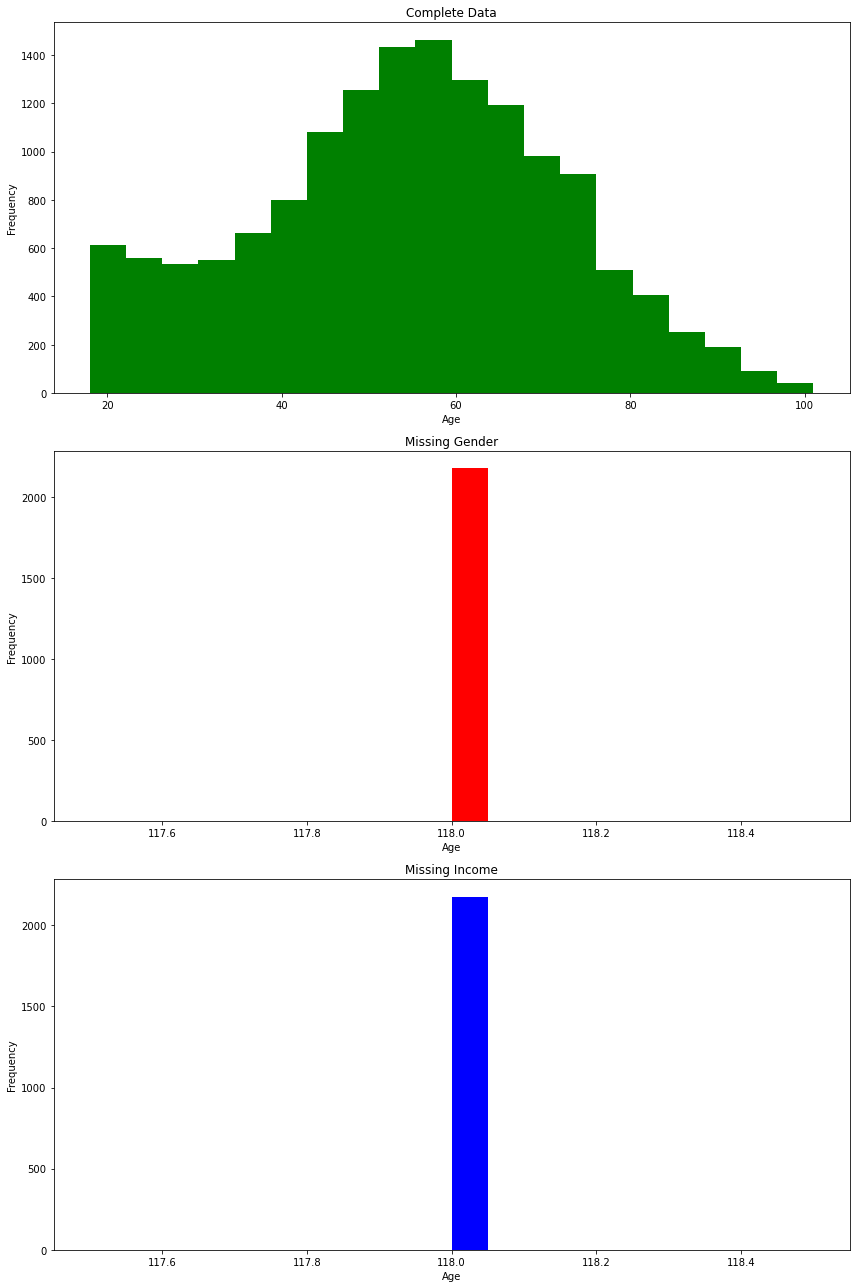

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))

axs[0].hist(complete_data_ages, bins=20, color='green')
axs[0].set_title('Complete Data')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

axs[1].hist(missing_gender_ages, bins=20, color='red')
axs[1].set_title('Missing Gender')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')

axs[2].hist(missing_income_ages, bins=20, color='blue')
axs[2].set_title('Missing Income')
axs[2].set_xlabel('Age')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
'''118 is a placeholder for missing value of gender and income
, remove these records'''
profile_df = profile_df[profile_df['age'] != 118]

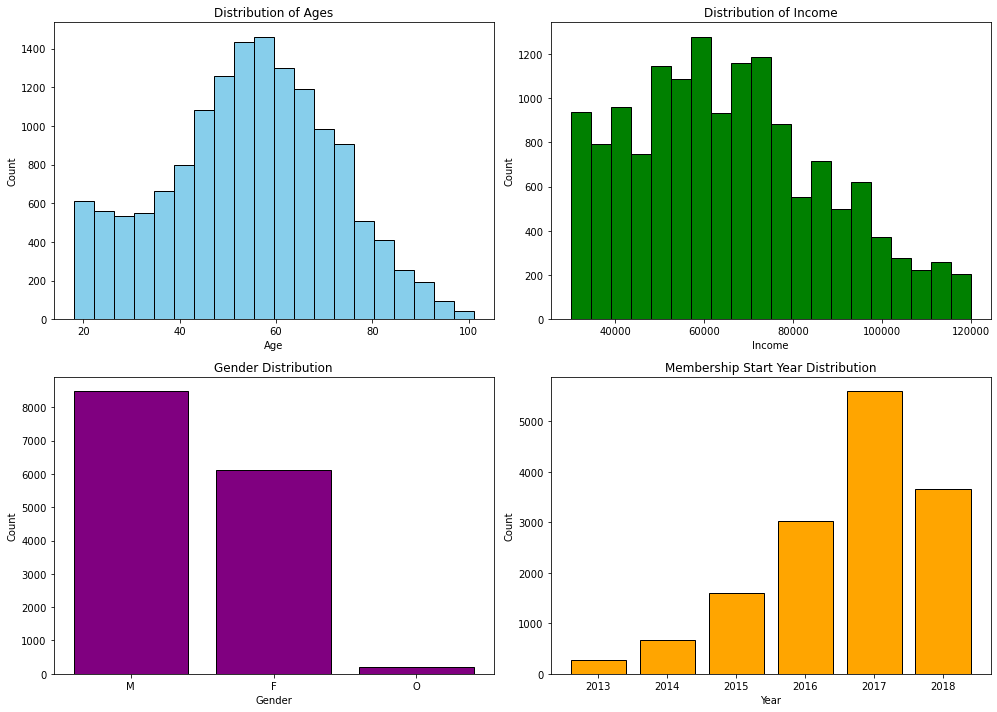

In [10]:

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Age Distribution
axs[0, 0].hist(profile_df['age'], bins=20, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Distribution of Ages')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Count')

# Income Distribution
axs[0, 1].hist(profile_df['income'].dropna(), bins=20, color='green', edgecolor='black')
axs[0, 1].set_title('Distribution of Income')
axs[0, 1].set_xlabel('Income')
axs[0, 1].set_ylabel('Count')

# Gender Distribution
gender_counts = profile_df['gender'].value_counts(dropna=False)
axs[1, 0].bar(gender_counts.index.astype(str), gender_counts.values, color='purple', edgecolor='black')
axs[1, 0].set_title('Gender Distribution')
axs[1, 0].set_xlabel('Gender')
axs[1, 0].set_ylabel('Count')

# Membership Start Year Distribution
year_counts = profile_df['membership_year'].value_counts().sort_index()
axs[1, 1].bar(year_counts.index.astype(str), year_counts.values, color='orange', edgecolor='black')
axs[1, 1].set_title('Membership Start Year Distribution')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Insights:**
- Distribution of Ages: The age distribution is bell-shaped and roughly symmetrical, peaking in the middle-age range, which suggests that the majority of users are middle-aged.

- Gender Distribution: There are significantly more males than females and a very small number of other genders.


- Distribution of Income: The income distribution shows a multi-modal pattern, with significant representation in middle income brackets, peaking around $60,000 to $80,000.

- Membership Start Year Distribution: The number of new memberships peaked in 2016 and 2017, with a noticeable decline afterward.


### portfolio df

In [42]:
portfolio_df.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [38]:
portfolio_df['offer_type'].value_counts()

offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

In [40]:
portfolio_df.shape

(10, 6)

In [41]:
portfolio_df['channels'].explode().unique()

array(['email', 'mobile', 'social', 'web'], dtype=object)

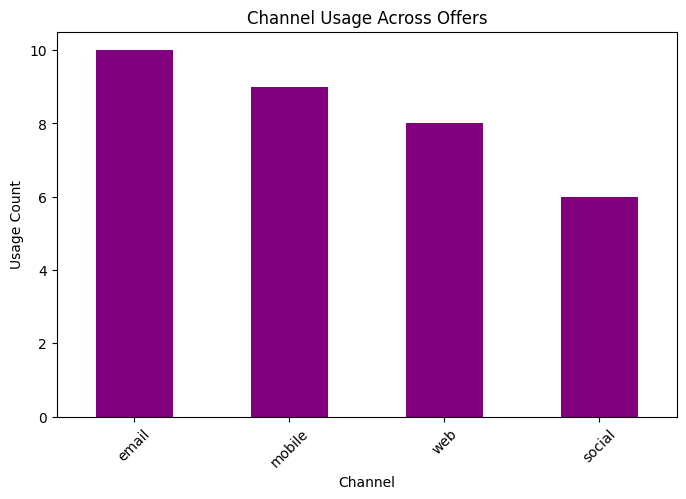

In [44]:
expanded_channels = portfolio_df['channels'].explode()
channel_counts = expanded_channels.value_counts()

# bar chart for channel usage
plt.figure(figsize=(8, 5))
channel_counts.plot(kind='bar', color='purple')
plt.title('Channel Usage Across Offers')
plt.xlabel('Channel')
plt.ylabel('Usage Count')
plt.xticks(rotation=45)
plt.show()

### transcript_df

In [43]:
transcript_df.shape

(306534, 4)

In [46]:
transcript_df.isna().mean()

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64

In [48]:
transcript_df.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [11]:
unique_events = transcript_df['event'].unique()
print(unique_events)

['offer received' 'offer viewed' 'transaction' 'offer completed']


In [12]:
transcript_df = transcript_df.join(transcript_df['value'].apply(pd.Series))
transcript_df.drop(columns=['value'], inplace=True)

In [52]:
transcript_df.head()

,person,event,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [101]:
offer_viewed = transcript_df[transcript_df['event'] == 'offer viewed']
offer_completed = transcript_df[transcript_df['event'] == 'offer completed']

print("Missing values in 'offer viewed':")
print(offer_viewed.isnull().sum())

print("\nMissing values in 'offer completed':")
print(offer_completed.isnull().sum())

Missing values in 'offer viewed':
person          0
event           0
time            0
amount      57725
offer_id        0
reward      57725
dtype: int64

Missing values in 'offer completed':
person          0
event           0
time            0
amount      33579
offer_id        0
reward          0
dtype: int64


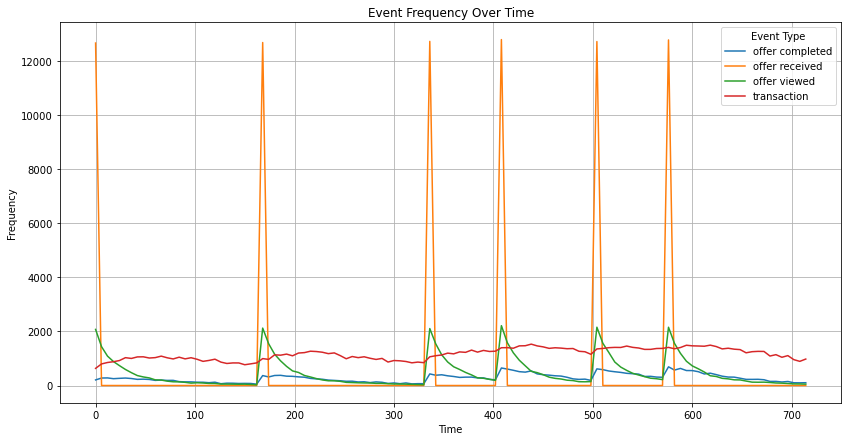

In [15]:
event_counts = transcript_df.groupby(['time', 'event']).size().unstack().fillna(0)

plt.figure(figsize=(14, 7))
for event in event_counts.columns:
    plt.plot(event_counts.index, event_counts[event], label=event)

plt.title('Event Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend(title='Event Type')
plt.grid(True)
plt.show()

**Insights:**

- This plot generally shows what've expected when send out offers to customers, after each offer sent out, the number of views and completions increased also transactions shows a slight increase and then have a little decrease waiting for the next stimulation.

In [27]:
transcript_port_df.isna().mean()

person        0.000000
event         0.000000
time          0.000000
offer id      0.562848
amount        0.546696
offer_id      0.890456
reward        0.890456
id            0.562848
offer_type    0.562848
dtype: float64

In [16]:
both_non_null = transcript_df.dropna(subset=['offer_id', 'offer id'])

# Verify if the entries in both columns match where both are non-null
consistency_check = (both_non_null['offer_id'] == both_non_null['offer id']).all()


missing_data_pattern = transcript_df[['offer_id', 'offer id']].isnull().sum()

print("Consistency where both columns are non-null:", consistency_check)
print("Missing data in each column:\n", missing_data_pattern)

Consistency where both columns are non-null: True
Missing data in each column:
 offer_id    272955
offer id    172532
dtype: int64


In [17]:
# Consolidate 'offer id' and 'offer_id' into one column 
transcript_df['offer_id'].fillna(transcript_df['offer id'], inplace=True)

transcript_df.drop(columns=['offer id'], inplace=True)

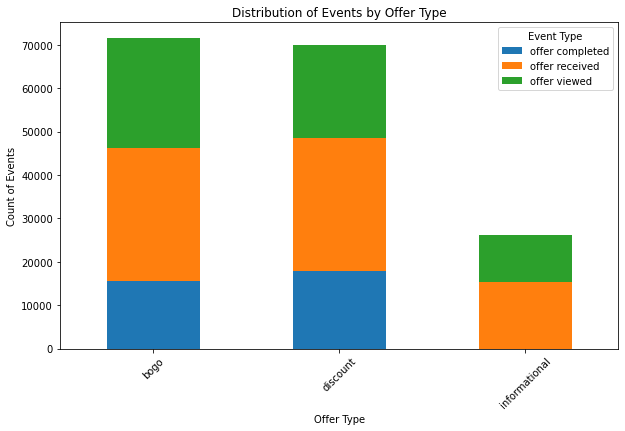

In [18]:
# Merge the transcript data with the portfolio data for offer types
transcript_port_df = transcript_df.merge(portfolio_df[['id', 'offer_type']], left_on='offer_id', right_on='id', how='left')

event_counts_by_offer_type = transcript_port_df.groupby(['offer_type', 'event']).size().unstack().fillna(0)


plt.figure(figsize=(10, 6))
event_counts_by_offer_type.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of Events by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Count of Events')
plt.legend(title='Event Type')
plt.xticks(rotation=45)
plt.show()

**Insights:**
- For both BOGO and Discount offers, the number of offers viewed is significantly higher than the number of offers completed
- Informational offers do not have a completion metric, as expected, because these offers are intended only to inform and engage customers without requiring a purchase or action that can be completed.
- BOGO offers have the highest total event counts across received and viewed, suggesting they are the most popular or frequently issued offer type compared to Discount and Informational.

In [16]:
event_counts_by_offer_type

event,offer completed,offer received,offer viewed
offer_type,,,
bogo,15669.0,30499.0,25449.0
discount,17910.0,30543.0,21445.0
informational,0.0,15235.0,10831.0


In [8]:
portfolio_df[portfolio_df.offer_type == 'informational']

,reward,channels,difficulty,duration,offer_type,id
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


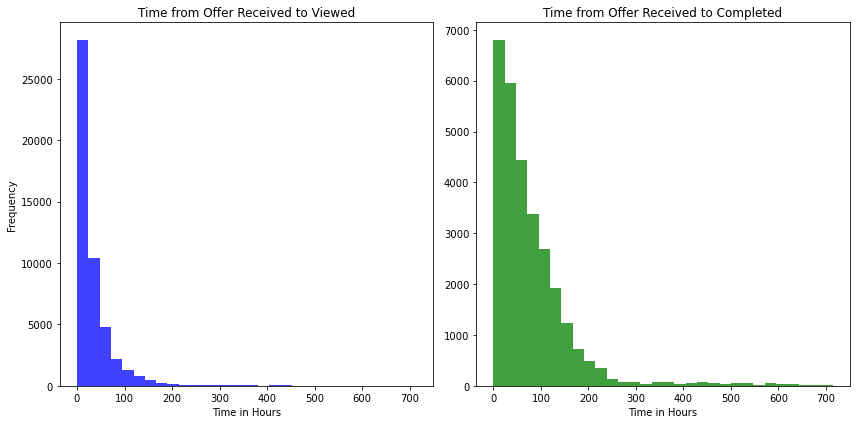

In [19]:
pivot_df = transcript_df.pivot_table(index=['person', 'offer_id'], columns='event', values='time', aggfunc='min')

pivot_df['time_to_view'] = pivot_df['offer viewed'] - pivot_df['offer received']
pivot_df['time_to_complete'] = pivot_df['offer completed'] - pivot_df['offer received']


time_to_view = pivot_df['time_to_view'].dropna()
time_to_complete = pivot_df['time_to_complete'].dropna()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(time_to_view, bins=30, alpha=0.75, color='blue')
plt.title('Time from Offer Received to Viewed')
plt.xlabel('Time in Hours')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(time_to_complete, bins=30, alpha=0.75, color='green')
plt.title('Time from Offer Received to Completed')
plt.xlabel('Time in Hours')

plt.tight_layout()
plt.show()

# Data Cleaning

In [20]:
data= transcript_df.merge(portfolio_df[['id', 'offer_type', 'difficulty', 'duration']], left_on='offer_id', right_on='id', how='left')

full_data = data.merge(profile_df, left_on='person', right_on='id', how='left')

full_data.head()
# from the merge result we can see that some of the person id in the transcript data
# are not available in profile_data

,person,event,time,amount,offer_id,reward,id_x,offer_type,difficulty,duration,gender,age,id_y,became_member_on,income,membership_year
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,7.0,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20.0,10.0,NaN,NaN,NaN,NaT,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,discount,10.0,7.0,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,discount,10.0,10.0,NaN,NaN,NaN,NaT,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,5.0,NaN,NaN,NaN,NaT,NaN,NaN


In [21]:
full_data.dropna(subset = ['id_y'],inplace = True)

In [22]:
full_data.columns

Index(['person', 'event', 'time', 'amount', 'offer_id', 'reward', 'id_x',
       'offer_type', 'difficulty', 'duration', 'gender', 'age', 'id_y',
       'became_member_on', 'income', 'membership_year'],
      dtype='object')

In [23]:
full_data.drop(columns=['id_x', 'id_y'], inplace=True)  
full_data['became_member_on'] = pd.to_datetime(full_data['became_member_on'], format='%Y%m%d')

full_data['gender'] = full_data['gender'].astype('category')
full_data['offer_type'] = full_data['offer_type'].astype('category')

print(full_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   person            272762 non-null  object        
 1   event             272762 non-null  object        
 2   time              272762 non-null  int64         
 3   amount            123957 non-null  float64       
 4   offer_id          148805 non-null  object        
 5   reward            32444 non-null   float64       
 6   offer_type        148805 non-null  category      
 7   difficulty        148805 non-null  float64       
 8   duration          148805 non-null  float64       
 9   gender            272762 non-null  category      
 10  age               272762 non-null  float64       
 11  became_member_on  272762 non-null  datetime64[ns]
 12  income            272762 non-null  float64       
 13  membership_year   272762 non-null  float64       
dtypes: c

In [24]:
full_data.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

In [72]:
full_data.shape

(272762, 17)

In [27]:
# Binning age and income
full_data['age_group'] = pd.cut(full_data['age'], bins=[0,18, 30, 45, 60, 75, 100], labels=['<18','18-30', '31-45', '46-60', '61-75', '76-100'])
full_data['income_group'] = pd.cut(full_data['income'], bins=[0,30000, 50000, 70000, 90000, 120000], labels=['<30k','30k-50k', '50k-70k', '70k-90k', '90k-120k'])



In [28]:
grouped = full_data.groupby(['person'])

stats = grouped.agg(
    offer_received=('event', lambda x: (x == 'offer received').sum()),
    offer_viewed=('event', lambda x: (x == 'offer viewed').sum()),
    offer_completed=('event', lambda x: (x == 'offer completed').sum()),
    transactions=('event', lambda x: (x == 'transaction').sum())  # Counting transactions
)

# Calculate rates only for those who have received offers
stats['general_view_rate'] = stats.apply(lambda x: x['offer_viewed'] / x['offer_received'] if x['offer_received'] > 0 else 0, axis=1)
stats['general_completion_rate'] = stats.apply(lambda x: x['offer_completed'] / x['offer_received'] if x['offer_received'] > 0 else 0, axis=1)


In [29]:
offers_data = full_data[full_data['event'].isin(['offer received', 'offer viewed', 'offer completed'])]
# Clcaulte view rate and completion rate for each offer type
def create_offer_type_columns(data, offer_types):
    rate_df = pd.DataFrame(data['person'].unique(), columns=['person'])
    
    for offer_type in offer_types:
        # Group by person and specific offer type
        grouped = data[data['offer_type'] == offer_type].groupby('person').agg(
            offers_received=('event', lambda x: (x == 'offer received').sum()),
            offers_viewed=('event', lambda x: (x == 'offer viewed').sum()),
            offers_completed=('event', lambda x: (x == 'offer completed').sum())
        ).reset_index()
        
        # Calculate view and completion rates for specific offer type
        grouped[f'{offer_type}_view_rate'] = grouped['offers_viewed'].astype(float) / grouped['offers_received'].astype(float)
        grouped[f'{offer_type}_completion_rate'] = grouped['offers_completed'].astype(float) / grouped['offers_received'].astype(float)
        

        rate_df = rate_df.merge(grouped[['person', f'{offer_type}_view_rate', f'{offer_type}_completion_rate']], on='person', how='left')
    
    return rate_df

offer_types = offers_data['offer_type'].unique()
offers_rates = create_offer_type_columns(offers_data, offer_types)


In [30]:
offers_rates.columns

Index(['person', 'bogo_view_rate', 'bogo_completion_rate',
       'discount_view_rate', 'discount_completion_rate',
       'informational_view_rate', 'informational_completion_rate'],
      dtype='object')

In [31]:
full_data2 = full_data.merge(stats, on='person', how='left')
full_data2 = full_data2.merge(offers_rates[['person','bogo_view_rate', 'bogo_completion_rate',
       'discount_view_rate', 'discount_completion_rate',
       'informational_view_rate', 'informational_completion_rate']], on='person', how='left')

In [32]:
# Fill NaN values in the rate columns with zero
rate_columns = [col for col in full_data2.columns if 'rate' in col]
full_data2[rate_columns] = full_data2[rate_columns].fillna(0)

In [23]:
stats.describe()

,offer_received,offer_viewed,offer_completed,transactions,view_rate,completion_rate
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,4.485734,3.363238,2.188465,8.361349,0.753270,0.487377
std,1.074694,1.291316,1.582193,5.182667,0.236818,0.331082
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2.000000,1.000000,4.000000,0.600000,0.200000
50%,5.000000,3.000000,2.000000,7.000000,0.800000,0.500000
75%,5.000000,4.000000,3.000000,11.000000,1.000000,0.750000
max,6.000000,6.000000,6.000000,36.000000,1.000000,1.000000


In [51]:
full_data2.head()

,person,event,time,amount,offer_id,reward,offer_type,difficulty,duration,gender,age,became_member_on,income,membership_year,age_group,income_group,income_offer_interaction,offer_received,offer_viewed,offer_completed,transactions,general_view_rate,general_completion_rate,bogo_view_rate,bogo_completion_rate,discount_view_rate,discount_completion_rate,informational_view_rate,informational_completion_rate
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,bogo,5.0,7.0,F,75.0,2017-05-09,100000.0,2017.0,61-75,90k-120k,90k-120k_bogo,4,4,3,7,1.000000,0.750000,1.0,1.00,0.0,0.0,1.0,0.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,discount,10.0,7.0,M,68.0,2018-04-26,70000.0,2018.0,61-75,50k-70k,50k-70k_discount,4,3,2,3,0.750000,0.500000,1.0,1.00,1.0,0.5,0.0,0.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,bogo,5.0,5.0,M,65.0,2018-02-09,53000.0,2018.0,61-75,50k-70k,50k-70k_bogo,6,6,5,3,1.000000,0.833333,1.0,0.75,1.0,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,informational,0.0,4.0,M,58.0,2017-11-11,51000.0,2017.0,46-60,50k-70k,50k-70k_informational,3,2,1,4,0.666667,0.333333,0.0,0.00,1.0,0.5,0.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,20.0,10.0,F,61.0,2017-09-11,57000.0,2017.0,61-75,50k-70k,50k-70k_discount,5,5,3,6,1.000000,0.600000,1.0,1.00,1.0,0.0,1.0,0.0


In [54]:
full_data2.columns

Index(['person', 'event', 'time', 'amount', 'offer_id', 'reward', 'offer_type',
       'difficulty', 'duration', 'gender', 'age', 'became_member_on', 'income',
       'membership_year', 'age_group', 'income_group',
       'income_offer_interaction', 'offer_received', 'offer_viewed',
       'offer_completed', 'transactions', 'general_view_rate',
       'general_completion_rate', 'bogo_view_rate', 'bogo_completion_rate',
       'discount_view_rate', 'discount_completion_rate',
       'informational_view_rate', 'informational_completion_rate',
       'age_offer_interaction', 'gender_offer_interaction',
       'age_income_offer_interaction', 'membership_tenure_days',
       'membership_tenure_years'],
      dtype='object')

In [34]:
# Create interaction terms between demographics and offer attributes
full_data2['age_offer_interaction'] = full_data2['age_group'].astype(str) + '_' + full_data2['offer_type'].astype(str)
full_data2['income_offer_interaction'] = full_data2['income_group'].astype(str) + '_' + full_data2['offer_type'].astype(str)
full_data2['gender_offer_interaction'] = full_data2['gender'].astype(str) + '_' + full_data2['offer_type'].astype(str)

full_data2['age_income_offer_interaction'] = full_data2['age_group'].astype(str) + '_' + full_data2['income_group'].astype(str) + '_' + full_data2['offer_type'].astype(str)

current_date = pd.to_datetime('today')
full_data2['membership_tenure_days'] = (current_date - full_data2['became_member_on']).dt.days

full_data2['membership_tenure_years'] = full_data2['membership_tenure_days'] / 365.25

In [35]:
# Drop duplicates at the person level for demographic data for visualization purpose
plot_data = full_data2.drop_duplicates(subset='person',keep = 'first').reset_index(drop=True)

In [56]:
plot_data.head()

,person,event,time,amount,offer_id,reward,offer_type,difficulty,duration,gender,age,became_member_on,income,membership_year,age_group,income_group,income_offer_interaction,offer_received,offer_viewed,offer_completed,transactions,general_view_rate,general_completion_rate,bogo_view_rate,bogo_completion_rate,discount_view_rate,discount_completion_rate,informational_view_rate,informational_completion_rate,age_offer_interaction,gender_offer_interaction,age_income_offer_interaction,membership_tenure_days,membership_tenure_years
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,bogo,5.0,7.0,F,75.0,2017-05-09,100000.0,2017.0,61-75,90k-120k,90k-120k_bogo,4,4,3,7,1.000000,0.750000,1.0,1.00,0.0,0.0,1.0,0.0,61-75_bogo,F_bogo,61-75_90k-120k_bogo,2800,7.665982
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,discount,10.0,7.0,M,68.0,2018-04-26,70000.0,2018.0,61-75,50k-70k,50k-70k_discount,4,3,2,3,0.750000,0.500000,1.0,1.00,1.0,0.5,0.0,0.0,61-75_discount,M_discount,61-75_50k-70k_discount,2448,6.702259
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,bogo,5.0,5.0,M,65.0,2018-02-09,53000.0,2018.0,61-75,50k-70k,50k-70k_bogo,6,6,5,3,1.000000,0.833333,1.0,0.75,1.0,1.0,0.0,0.0,61-75_bogo,M_bogo,61-75_50k-70k_bogo,2524,6.910335
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,informational,0.0,4.0,M,58.0,2017-11-11,51000.0,2017.0,46-60,50k-70k,50k-70k_informational,3,2,1,4,0.666667,0.333333,0.0,0.00,1.0,0.5,0.0,0.0,46-60_informational,M_informational,46-60_50k-70k_informational,2614,7.156742
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,discount,20.0,10.0,F,61.0,2017-09-11,57000.0,2017.0,61-75,50k-70k,50k-70k_discount,5,5,3,6,1.000000,0.600000,1.0,1.00,1.0,0.0,1.0,0.0,61-75_discount,F_discount,61-75_50k-70k_discount,2675,7.323751


# Insights from data

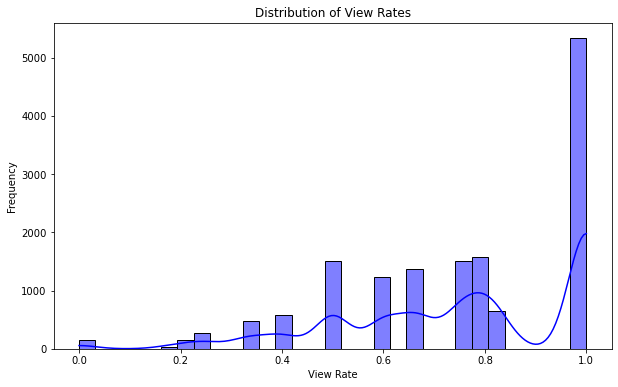

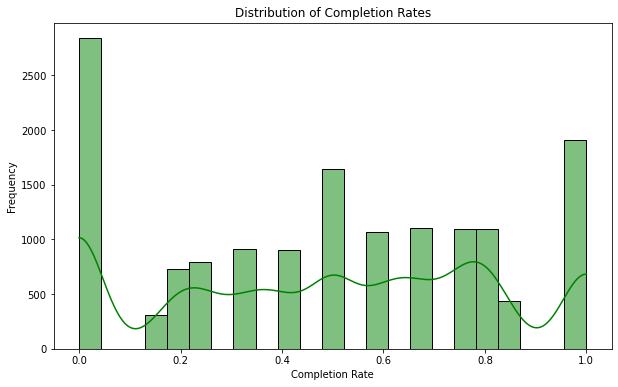

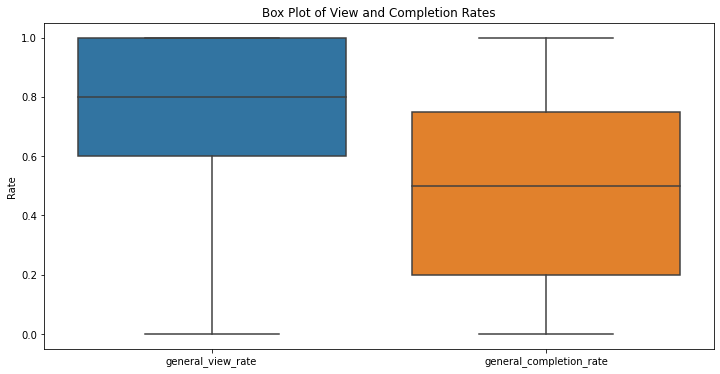

In [36]:
# Plot the distribution of the rate and see whether it makes sense
# Histogram of view_rate
plt.figure(figsize=(10, 6))
sns.histplot(plot_data['general_view_rate'], kde=True, color='blue')
plt.title('Distribution of View Rates')
plt.xlabel('View Rate')
plt.ylabel('Frequency')
plt.show()

# Histogram of completion_rate
plt.figure(figsize=(10, 6))
sns.histplot(plot_data['general_completion_rate'], kde=True, color='green')
plt.title('Distribution of Completion Rates')
plt.xlabel('Completion Rate')
plt.ylabel('Frequency')
plt.show()

# Boxplot for view_rate and completion_rate
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_data[['general_view_rate', 'general_completion_rate']])
plt.title('Box Plot of View and Completion Rates')
plt.ylabel('Rate')
plt.show()

### **Age vs. Rate Insights:**
- View rate is similar across different buckets when people getting older than 30
- Completion rate is lowest from 18-30, and kind of low for yournger people, so when we consider about sending offers, we may focus on people over 35 

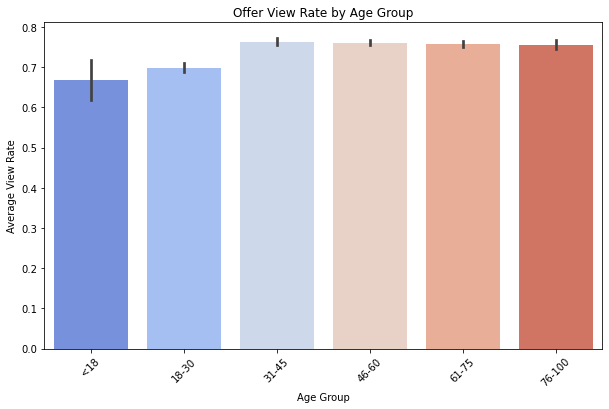

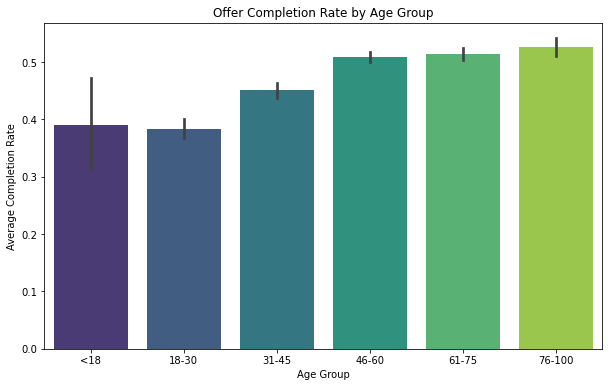

In [37]:

# Bar Chart for View Rate by Age Group
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='general_view_rate', data=plot_data, palette='coolwarm')
plt.title('Offer View Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average View Rate')
plt.xticks(rotation=45)
plt.show()

# Bar Chart for Completion Rate by Age group
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='general_completion_rate', data=plot_data, palette='viridis')
plt.title('Offer Completion Rate by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Completion Rate')
plt.show()


### **Gender vs. Rate Insights:**
- View rate is similar across gender groups
- Female are more likely to complete their offer, so might prioritize female for offer targeting purpose

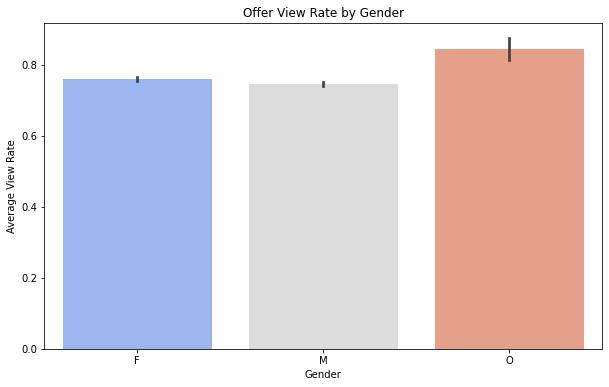

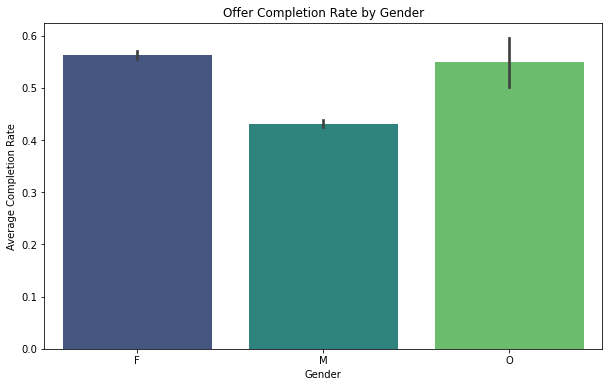

In [38]:
# Bar Chart for View Rate by Gender Group
plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='general_view_rate', data=plot_data, palette='coolwarm')
plt.title('Offer View Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Average View Rate')
plt.show()

# Bar Chart for Completion Rate by Gender
plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='general_completion_rate', data=plot_data, palette='viridis')
plt.title('Offer Completion Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Completion Rate')
plt.show()

### **Income vs. Rate Insights:**
- View rate reach the peak at middle range income group, indicating people who have income around 50k-90k are more likely to engage with offers.
- Completion rate increases as income increases which makes sense from affordability perspective, but this also influenced by number of data points we have for each group

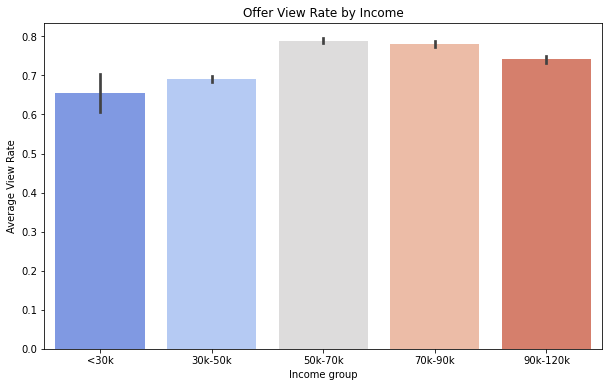

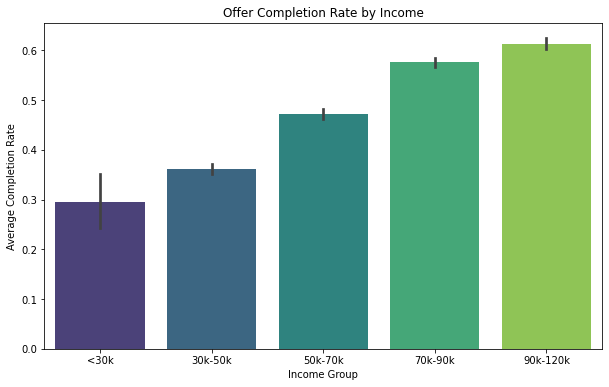

In [39]:
# Bar Chart for View Rate by Income Group
plt.figure(figsize=(10, 6))
sns.barplot(x='income_group', y='general_view_rate', data=plot_data, palette='coolwarm')
plt.title('Offer View Rate by Income')
plt.xlabel('Income group')
plt.ylabel('Average View Rate')
plt.show()

# Bar Chart for Completion Rate by Income
plt.figure(figsize=(10, 6))
sns.barplot(x='income_group', y='general_completion_rate', data=plot_data, palette='viridis')
plt.title('Offer Completion Rate by Income')
plt.xlabel('Income Group')
plt.ylabel('Average Completion Rate')
plt.show()

### Correlation Matrix Insights

- **Number of Transactions** show moderate positive correlations with offer completions across BOGO, Discount, and General completion rates (0.37, 0.37, and 0.37 respectively). This suggests that higher transaction activity is associated with higher offer completion rates, indicating that active buyers are more likely to fulfill the conditions of the offers.

- **Membership tenure** shows a slight positive correlation with the general view rate (0.26) and general completion rate (0.28). This implies that longer-tenured members tend to engage slightly more with offers, potentially due to greater familiarity with or loyalty to the platform.

- **Age** shows very low correlations with most of the offer interaction rates, indicating that age, by itself, does not significantly influence how offers are received, viewed, or completed. The highest correlation age has is with membership tenure years (0.31), which could imply that older demographics tend to be long-term members.


- **Income** displays a very low correlation with offer interaction rates, suggesting that income levels do not significantly influence the rates at which offers are viewed or completed. However, it shows a slight correlation with general completion rate (0.20), indicating a minor tendency for higher income members to complete offers more frequently than lower income ones.

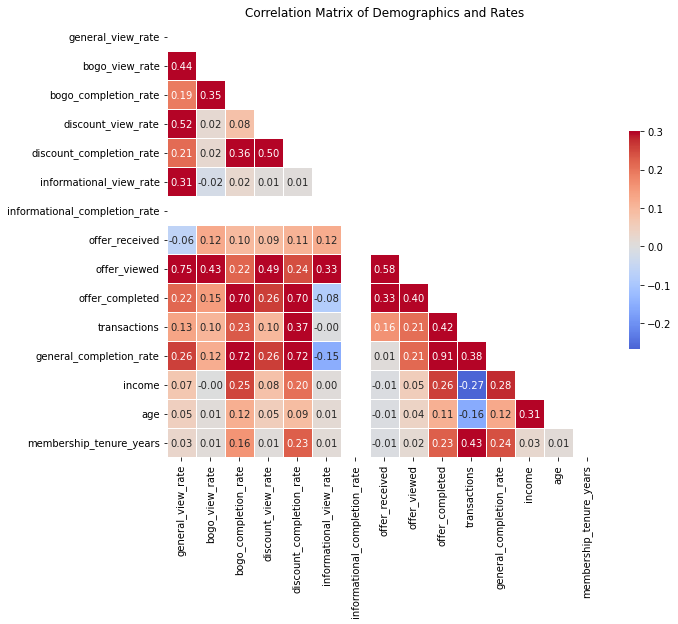

In [40]:
corr = plot_data[['general_view_rate', 
                  'bogo_view_rate', 'bogo_completion_rate',
       'discount_view_rate', 'discount_completion_rate',
       'informational_view_rate', 'informational_completion_rate','offer_received', 'offer_viewed',
       'offer_completed', 'transactions',
                  'general_completion_rate', 'income', 'age', 'membership_tenure_years']].corr(method='pearson')


mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Matrix of Demographics and Rates')
plt.show()

# Deeper segment analysis

In [41]:
segment_analysis = plot_data.groupby(['age_group', 'income_group', 'gender', 'offer_type', 'difficulty', 'duration']).agg({
    'general_view_rate': 'mean',
    'general_completion_rate': 'mean',
    'bogo_view_rate': 'mean',
    'bogo_completion_rate': 'mean',
    'discount_view_rate': 'mean',
    'discount_completion_rate': 'mean',
    'informational_view_rate': 'mean',
    'informational_completion_rate': 'mean'
}).reset_index()


segment_analysis['count'] = plot_data.groupby(['age_group', 'income_group', 'gender', 'offer_type', 'difficulty', 'duration']).size().reset_index(name='count')['count']
segment_analysis.sort_values(by='general_completion_rate', ascending=False, inplace=True)

print(segment_analysis.head())

     age_group income_group gender offer_type  difficulty  duration  \
2633     31-45      30k-50k      O       bogo         5.0       7.0   
5368     61-75      70k-90k      O   discount        10.0       7.0   
718        <18      70k-90k      F   discount        10.0       7.0   
3242     31-45     90k-120k      M       bogo        10.0       5.0   
5369     61-75      70k-90k      O   discount        10.0      10.0   

      general_view_rate  general_completion_rate  bogo_view_rate  \
2633                0.8                      1.0             1.0   
5368                1.0                      1.0             1.0   
718                 0.6                      1.0             1.0   
3242                1.0                      1.0             1.0   
5369                1.0                      1.0             0.0   

      bogo_completion_rate  discount_view_rate  discount_completion_rate  \
2633                   1.0            0.666667                       1.0   
5368        

In [45]:
plot_data.bogo_completion_rate.mean()

0.50441483979764

### Age vs. BOGO offer
- Increasing Trend with Age: There is a clear increasing trend in both the BOGO view and completion rates as age increases. Younger age groups (below 18 and 18-30) show lower engagement with BOGO offers both in terms of viewing and completing the offers. This trend suggests that older age groups may find more value in BOGO offers, or perhaps they have more purchasing power or interest in such promotions.

- Higher Completion Rate Consistency: Despite fluctuations in the view rates among the different age groups, the completion rates consistently increase with age. This indicates that once older age groups view the offer, they are more likely to complete it compared to younger groups, emphasizing the importance of targeting and tailoring offers that appeal to the older demographic’s preferences and shopping behaviors.

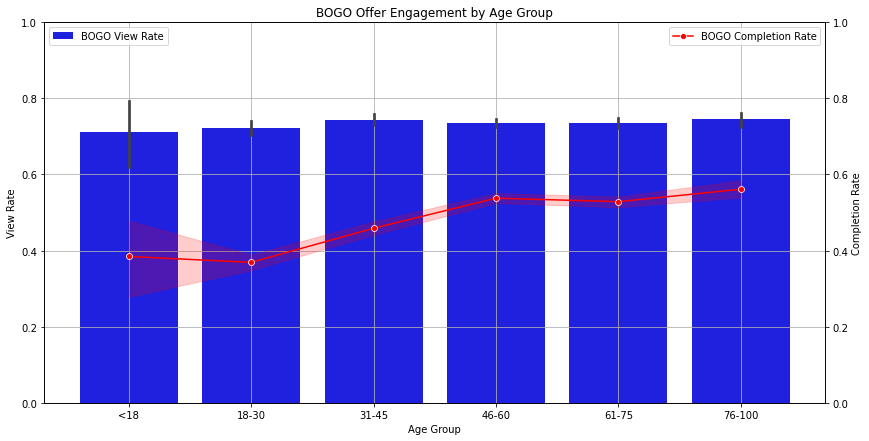

In [51]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for BOGO View Rates
sns.barplot(x='age_group', y='bogo_view_rate', data=plot_data, color='blue', ax=ax1, label='BOGO View Rate')
ax1.set_ylabel('View Rate')
ax1.set_ylim(0, 1)  


ax2 = ax1.twinx()
sns.lineplot(x='age_group', y='bogo_completion_rate', data=plot_data, color='red', marker='o', ax=ax2, label='BOGO Completion Rate')
ax2.set_ylabel('Completion Rate')
ax2.set_ylim(0, 1)  


ax1.grid(True)
ax2.grid(False) 

ax1.set_title('BOGO Offer Engagement by Age Group')
ax1.set_xlabel('Age Group')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Age vs. Discount offer
- Stable Completion Rates Across Ages: Unlike the BOGO offers, the Discount offer completion rates are very consistent across all age groups, hovering around 0.45 to 0.50. This indicates a uniform effectiveness of Discount offers in terms of completion, regardless of the age group, which suggests that these offers appeal broadly across different demographics.
- Dip in View Rates for Young Adults: There is an initial dip in the view rates for the 18-30 age group compared to the younger <18 group, followed by a relatively stable view rate across the older age groups. This might suggest a need to adjust how Discount offers are marketed to young adults to increase their visibility and engagement with these offers.

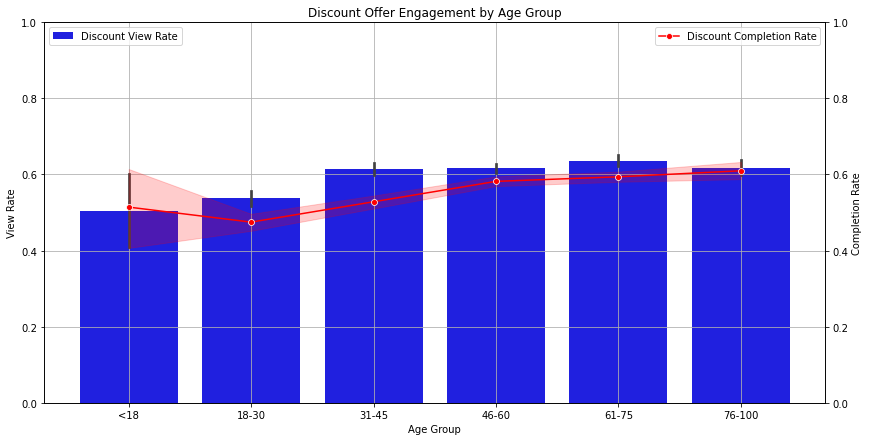

In [52]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for Discount View Rates
sns.barplot(x='age_group', y='discount_view_rate', data=plot_data, color='blue', ax=ax1, label='Discount View Rate')
ax1.set_ylabel('View Rate')
ax1.set_ylim(0, 1)  


ax2 = ax1.twinx()
sns.lineplot(x='age_group', y='discount_completion_rate', data=plot_data, color='red', marker='o', ax=ax2, label='Discount Completion Rate')
ax2.set_ylabel('Completion Rate')
ax2.set_ylim(0, 1) 


ax1.grid(True)
ax2.grid(False)  

ax1.set_title('Discount Offer Engagement by Age Group')
ax1.set_xlabel('Age Group')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Income vs. BOGO offer
- Increasing Completion Rate with Income: There is a clear ascending trend in the BOGO completion rate as income increases. This suggests that higher income groups are more likely to complete BOGO offers, which might indicate a greater purchasing power or inclination to engage with offers that provide a “buy one, get one” incentive.
- View Rate Stability Across Income Groups: The BOGO view rate remains relatively consistent across all income groups, suggesting that interest in viewing BOGO offers does not significantly vary by income. This uniformity in view rates across different income levels indicates that while all groups are equally interested in BOGO offers, the ability or decision to complete the offer correlates with higher income levels.

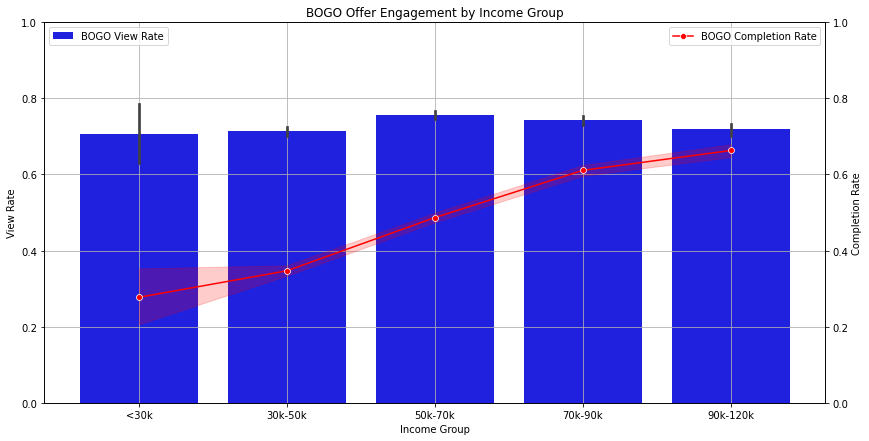

In [63]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for BOGO View Rates
sns.barplot(x='income_group', y='bogo_view_rate', data=plot_data, color='blue', ax=ax1, label='BOGO View Rate')
ax1.set_ylabel('View Rate')
ax1.set_ylim(0, 1)  


ax2 = ax1.twinx()
sns.lineplot(x='income_group', y='bogo_completion_rate', data=plot_data, color='red', marker='o', ax=ax2, label='BOGO Completion Rate')
ax2.set_ylabel('Completion Rate')
ax2.set_ylim(0, 1)  


ax1.grid(True)
ax2.grid(False)  

ax1.set_title('BOGO Offer Engagement by Income Group')
ax1.set_xlabel('Income Group')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

### Income vs. Discount offer
- Consistent View Rate Across Income Levels: The view rate for Discount offers remains relatively consistent across all income groups. This indicates that interest in viewing Discount offers does not vary significantly based on income, but do have more variance than BOGO offer indicating Discount offer has more preference across different income group.
- Rising Completion Rate with Increasing Income: There is a clear upward trend in the completion rate of Discount offers as income increases. This pattern suggests that as income rises, so does the likelihood of completing Discount offers. 

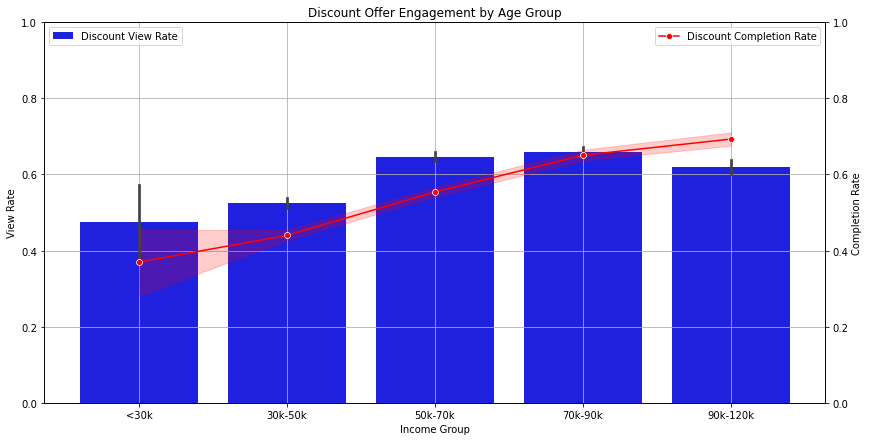

In [64]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Bar plot for Discount View Rates
sns.barplot(x='income_group', y='discount_view_rate', data=plot_data, color='blue', ax=ax1, label='Discount View Rate')
ax1.set_ylabel('View Rate')
ax1.set_ylim(0, 1)  


ax2 = ax1.twinx()
sns.lineplot(x='income_group', y='discount_completion_rate', data=plot_data, color='red', marker='o', ax=ax2, label='Discount Completion Rate')
ax2.set_ylabel('Completion Rate')
ax2.set_ylim(0, 1)  


ax1.grid(True)
ax2.grid(False)  

ax1.set_title('Discount Offer Engagement by Age Group')
ax1.set_xlabel('Income Group')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

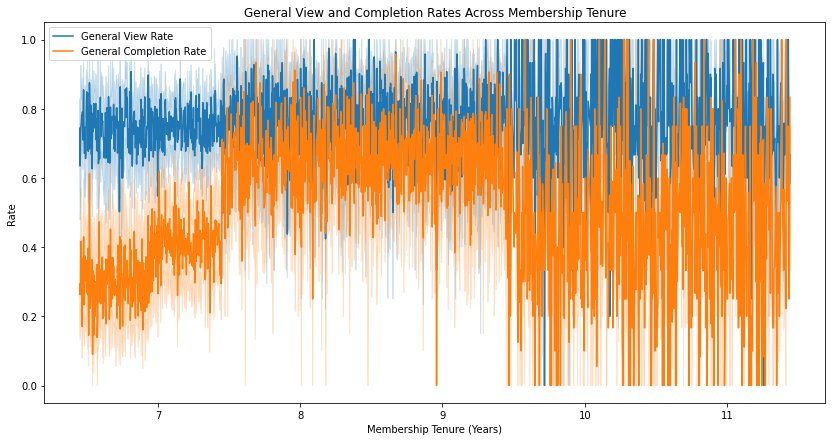

In [66]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='membership_tenure_years', y='general_view_rate', data=plot_data, label='General View Rate')
sns.lineplot(x='membership_tenure_years', y='general_completion_rate', data=plot_data, label='General Completion Rate')
plt.title('General View and Completion Rates Across Membership Tenure')
plt.xlabel('Membership Tenure (Years)')
plt.ylabel('Rate')
plt.legend()
plt.show()

### Transaction Frequency vs. Gender vs. Age

- Peak Activity in Middle Age Groups: The graph below shows a peak in transaction activity among the 31-45 and 46-60 age groups across all genders. This suggests that middle-aged customers are the most active.
- Males in the 31-45 and 46-60 age groups exhibit notably higher transaction frequencies compared to females and other genders in the same age range.

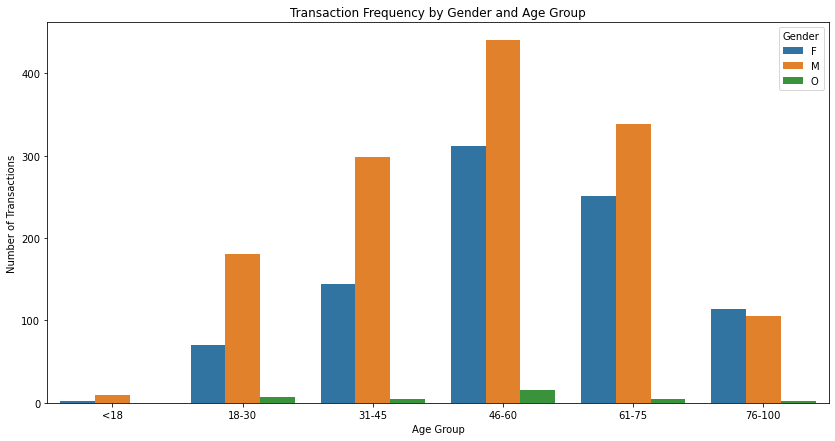

In [67]:
plt.figure(figsize=(14, 7))
sns.countplot(x='age_group', hue='gender', data=plot_data[plot_data['event'] == 'transaction'])
plt.title('Transaction Frequency by Gender and Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Transactions')
plt.legend(title='Gender')
plt.show()

# Summary from visualization result

**1.BOGO Offers for Higher Income Young Adults:**
- Target Group: Individuals in the age group of 18-30, particularly those with incomes in the higher brackets (70k-120k).
- Rationale: This demographic shows a rising trend in both BOGO offer view and completion rates as income increases. Young adults with higher disposable incomes may be more incentivized to take advantage of BOGO offers.

**2.Discount Offers for Middle-Aged Adults:**
- Target Group: Individuals within the age groups of 31-60, across all income brackets.
- Rationale: Consistently high completion rates for discount offers in these age groups suggest that middle-aged adults, who might be managing household budgets, find direct discounts more appealing and actionable. 

**3.	Informational Offers for Older Adults:**
- Target Group: Individuals in the age group of 61-100.
- Rationale: Older adults show a gradual increase in engagement with informational offers, particularly as they move into higher age brackets. Informational content may be valuable for this demographic, providing insights or awareness about products which can lead to informed purchasing decisions without the immediate pressure of completing a sale.
    

# Modeling

In [79]:
finalized_data = full_data2.dropna(subset = ['age_group','offer_type'])

In [96]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split


conditions = [
    (finalized_data['bogo_completion_rate'] >= finalized_data['discount_completion_rate']) & 
    (finalized_data['bogo_completion_rate'] >= finalized_data['informational_view_rate']),
    (finalized_data['discount_completion_rate'] >= finalized_data['bogo_completion_rate']) & 
    (finalized_data['discount_completion_rate'] >= finalized_data['informational_view_rate']),
    (finalized_data['informational_view_rate'] >= finalized_data['bogo_completion_rate']) & 
    (finalized_data['informational_view_rate'] >= finalized_data['discount_completion_rate'])
]


choices = ['bogo', 'discount', 'informational']


finalized_data['preferred_offer_type'] = np.select(conditions, choices, default='bogo')


X = pd.get_dummies(finalized_data[['gender', 'membership_tenure_days','transactions',
                                   'income_group', 'age_group']],
                    columns=['gender', 'income_group', 'age_group'])

y = finalized_data['preferred_offer_type']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


rf = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
}


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')


grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

/var/folders/db/0dwf3kds6j10nl3vmlwx57tc0000gn/T/ipykernel_56805/2819746197.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalized_data['preferred_offer_type'] = np.select(conditions, choices, default='bogo')


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   3.9s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   7.5s
[CV] END .max_depth=10, min_samples_leaf=4, n_estimators=100; total time=   3.8s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=100; total time=   5.6s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=300; total time=  17.1s
[CV] END .max_depth=20, min_samples_leaf=4, n_estimators=200; total time=  10.8s
[CV] END .max_depth=30, min_samples_leaf=1, n_estimators=300; total time=  18.2s


/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=   3.8s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time=   7.7s
[CV] END .max_depth=10, min_samples_leaf=4, n_estimators=300; total time=  11.0s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=300; total time=  17.3s
[CV] END .max_depth=20, min_samples_leaf=4, n_estimators=200; total time=  10.4s
[CV] END .max_depth=30, min_samples_leaf=1, n_estimators=300; total time=  17.8s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   7.6s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=300; total time=  11.2s
[CV] END .max_depth=20, min_samples_leaf=1, n_estimators=200; total time=  11.7s
[CV] END .max_depth=20, min_samples_leaf=2, n_estimators=300; total time=  16.9s
[CV] END .max_depth=30, min_samples_leaf=1, n_estimators=100; total time=   6.0s
[CV] END .max_depth=30, min_samples_leaf=1, n_estimators=300; total time=  17.7s
Best parameters found:  {'ma

In [97]:
# Best parameter model 
best_params = grid_search.best_params_
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, random_state=42)

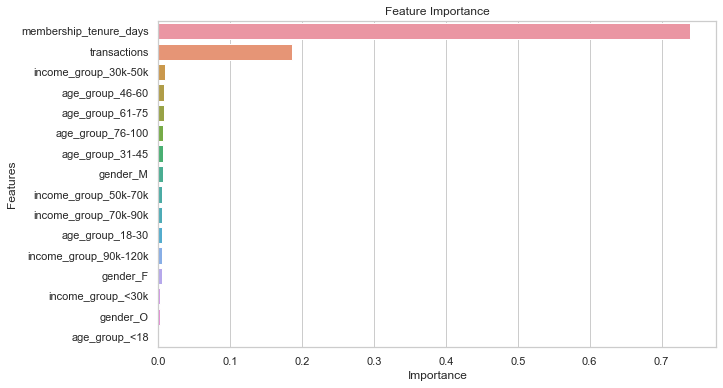

In [98]:
# Get feature importances
importances = rf_best.feature_importances_

feature_names = X_train.columns


importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importances_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = rf_best.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.9882223238054263
               precision    recall  f1-score   support

         bogo       0.99      0.99      0.99     21531
     discount       0.98      0.99      0.98     10100
informational       0.98      0.98      0.98      5558

     accuracy                           0.99     37189
    macro avg       0.99      0.98      0.99     37189
 weighted avg       0.99      0.99      0.99     37189

Confusion Matrix:
 [[21365   107    59]
 [  107  9959    34]
 [   59    72  5427]]


In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_best = RandomForestClassifier(max_depth=30, min_samples_leaf=1, n_estimators=300, random_state=42)
rf_best.fit(X_train, y_train)

probabilities = rf_best.predict_proba(X_test)

thresholds = {
    'bogo': 0.5,
    'discount': 0.5,
    'informational': 0.3
}

offer_decision = (probabilities > np.array([thresholds[cls] for cls in rf_best.classes_])).astype(int)

print("Sample probability outputs:\n", probabilities[:5])
print("Decisions based on thresholds:\n", offer_decision[:5])

Sample probability outputs:
 [[9.80000000e-01 0.00000000e+00 2.00000000e-02]
 [9.40740741e-01 3.92592593e-02 2.00000000e-02]
 [9.99111111e-01 8.88888889e-04 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00]]
Decisions based on thresholds:
 [[1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]]
